# Import libralies

In [343]:
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
import investpy as ip
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import time
import re
import gc
import math

# Get symbols
get stock symbols listed in Nasdaq by pandas datareader.nasdaq_trader

In [2]:
symbols = get_nasdaq_symbols()
print(f'number of symbols: {symbols.shape[0]}')

number of symbols: 12106


In [3]:
symbols

,Nasdaq Traded,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
Symbol,,,,,,,,,,,
A,True,"Agilent Technologies, Inc. Common Stock",N,,False,100.0,False,NaN,A,A,False
AA,True,Alcoa Corporation Common Stock,N,,False,100.0,False,NaN,AA,AA,False
AAA,True,Listed Funds Trust AAF First Priority CLO Bond...,P,,True,100.0,False,NaN,AAA,AAA,False
AAAU,True,Goldman Sachs Physical Gold ETF Shares,Z,,True,100.0,False,NaN,AAAU,AAAU,False
AAC,True,Ares Acquisition Corporation Class A Ordinary ...,N,,False,100.0,False,NaN,AAC,AAC,False
...,...,...,...,...,...,...,...,...,...,...,...
ZXZZT,True,NASDAQ TEST STOCK,Q,G,False,100.0,True,N,NaN,ZXZZT,False
ZY,True,Zymergen Inc. - Common Stock,Q,Q,False,100.0,False,N,NaN,ZY,False
ZYME,True,Zymeworks Inc. Common Shares,N,,False,100.0,False,NaN,ZYME,ZYME,False


# Download historical data

## yfinance

### download Nasdaq stocks.

In [101]:
"""
price_history = yf.download(  # or pdr.get_data_yahoo(...
                                # tickers list or string as well
                                tickers = " ".join(symbols.index.to_list()),

                                # use "period" instead of start/end
                                # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
                                # (optional, default is '1mo')
                                period = "max",

                                # fetch data by interval (including intraday if period < 60 days)
                                # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
                                # (optional, default is '1d')
                                interval = "1d",

                                # group by ticker (to access via data['SPY'])
                                # (optional, default is 'column')
                                group_by = 'ticker',

                                # adjust all OHLC automatically
                                # (optional, default is False)
                                auto_adjust = True,

                                # download pre/post regular market hours data
                                # (optional, default is False)
                                prepost = True,

                                # use threads for mass downloading? (True/False/Integer)
                                # (optional, default is True)
                                threads = True,

                                # proxy URL scheme use use when downloading?
                                # (optional, default is None)
                                proxy = None
                            )

price_history = price_history.stack(level=0)
price_history = price_history.reset_index().rename(columns={'level_1': 'Symbol'})
price_history = price_history.sort_values(by=['Symbol', 'Date']).reset_index(drop=True)
price_history = price_history.dropna(axis=0, how='all', subset=['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']).reset_index(drop=True)
price_history = price_history.set_index('Date')
price_history.to_pickle('data/nasdaq_historical_price.pkl')
"""
price_history = pd.read_pickle('data/nasdaq_historical_price.pkl')

check a Symbol whose historical data failed download. 

In [5]:
symbols.loc['ROSS.W', :]

Nasdaq Traded                                                    True
Security Name       Ross Acquisition Corp II Warrants, each whole ...
Listing Exchange                                                    N
Market Category                                                      
ETF                                                             False
Round Lot Size                                                  100.0
Test Issue                                                      False
Financial Status                                                  NaN
CQS Symbol                                                    ROSS.WS
NASDAQ Symbol                                                   ROSS+
NextShares                                                      False
Name: ROSS.W, dtype: object

try to get historical data by specifing the NASDAQ Symbol 'ROSS+'.

In [6]:
yf.Ticker('ROSS+').history()

- ROSS+: No data found, symbol may be delisted


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


Perhaps these stocks have been delisted or changed markets.

### Check major ETF
- SPY: SPDR S&P 500 ETF Trust
- QQQ: Invesco QQQ Trust
- IWM: iShares Russell 2000 ETF
- DIA: SPDR Dow Jones Industrial Average ETF Trust
- VTI: Vanguard Total Stock Market Index Fund ETF Shares
- MDY: S&P Midcap 400 ETF
- DBC: Invesco DB Commodity Index Tracking Fund
- FEZ: SPDR EURO STOXX 50 ETF
- OEF: iShares S&P 100 ETF
- IWF: iShares Russell 1000 Growth ETF
- IWD: iShares Russell 1000 Value ETF
- PFF: iShares Preferred and Income Securities ETF
- VOO: Vanguard S&P 500 ETF
- IJH: iShares Core S&P Mid-Cap ETF
- IWO: iShares Russell 2000 Growth ETF
- IWN: iShares Russell 2000 Value ETF
- ACWI: iShares MSCI ACWI ETF
- IEMG: iShares Core MSCI Emerging Markets ETF

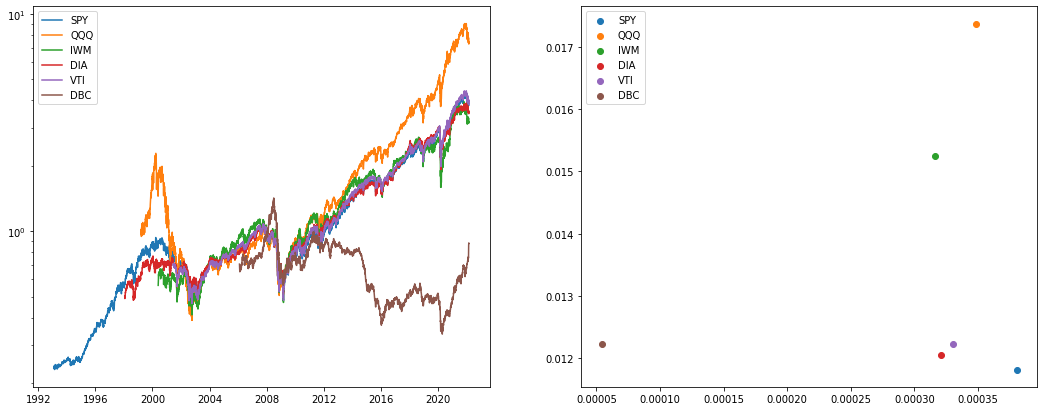

In [109]:
from datetime import datetime as dt
# index_etfs = ['SPY', 'QQQ', 'IWM', 'DIA', 'VTI', 'MDY', 'DBC', 'FEZ', 'OEF', 'IWF', 'IWD', 'PFF', 'VOO', 'IJH', 'IWO', 'IWN', 'ACWI', 'IEMG', ]
index_etfs = ['SPY', 'QQQ', 'IWM', 'DIA', 'VTI', 'DBC', ]
start_date = dt.strptime('2008-01-03', '%Y-%M-%d')

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
for index_etf in index_etfs:
    axes[0].set_yscale('log')
    axes[0].plot(index_history[index_history.Symbol == index_etf ]['Close']  \
                 / index_history[(index_history.Symbol == index_etf)]['Close']['2008-1-3'], label=index_etf)
    axes[1].scatter(index_history[index_history.Symbol == index_etf ]['Close'].apply(np.log).diff().mean(), \
                    index_history[index_history.Symbol == index_etf ]['Close'].apply(np.log).diff().std(), \
                   label=index_etf)
    axes[0].legend()
    axes[1].legend()

In [110]:
price_history

,Symbol,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
1999-11-18,A,NaN,27.066582,30.757481,24.605983,27.989305,62546380.0
1999-11-19,A,NaN,24.836662,26.451429,24.490640,26.412981,15234146.0
1999-11-22,A,NaN,27.066582,27.066582,24.644429,25.413366,6577870.0
1999-11-23,A,NaN,24.605980,26.835898,24.605980,26.143854,5975611.0
1999-11-24,A,NaN,25.259573,25.797829,24.605976,24.682870,4843231.0
...,...,...,...,...,...,...,...
2022-03-02,ZYXI,NaN,5.920000,6.130000,5.890000,6.050000,379000.0
2022-03-03,ZYXI,NaN,5.660000,6.000000,5.570000,5.990000,335400.0
2022-03-04,ZYXI,NaN,5.280000,5.540000,5.250000,5.540000,386400.0


In [36]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                       In|       376|
|                      Out|       640|
|                     axes|       112|
|                   df_tmp|   1940880|
|                       dt|       408|
|                     exit|        48|
|                      fig|        48|
|              get_ipython|        64|
|       get_nasdaq_symbols|       136|
|      index_close_columns|       120|
|               index_etfs|       152|
|            index_history|   2521536|
|        index_prices_2008|       112|
|                       np|        72|
|                       pd|        72|
|                      plt|        72|
|            price_history|7466463440|
|                     quit|        48|
|                  symbols|   4460543|
|                      sys|        72|
|                     tqdm|      1064|
|                      web|        72|
|                       yf|        72|


## investpy

### Download U.S. major indices 

In [114]:
"""
df_indices = ip.indices.get_indices('united states')
major_indices = df_indices[df_indices['class'] == 'major_indices']['name'].to_list()
additional_indices = df_indices[df_indices['class'] == 'additional_indices']['name'].to_list()
primary_sectors = df_indices[df_indices['class'] == 'primary_sectors']['name'].to_list()
major_index_histories = []
for index in major_indices:
    print(f'get {index} history.')
    df_tmp = ip.indices.get_index_historical_data(index, 'united states', '01/01/1900', '10/03/2022')
    df_tmp['name'] = index
    major_index_histories.append(df_tmp)
    # Use time.sleep(10) to prevent your IP address getting blacklisted. ref: https://github.com/alvarobartt/investpy/issues/467#issuecomment-959318542
    time.sleep(10)
df_major_index_history = pd.concat(major_index_histories)
df_major_index_history.to_pickle('data/major_indices_history.pkl')
"""
df_major_index_history = pd.read_pickle('data/major_indices_history.pkl')

get Dow 30 history.
get Nasdaq 100 history.
get Nasdaq history.
get S&P 500 history.
get MSCI US Net EUR history.
get MSCI US Net USD history.


In [124]:
df_major_index_history

,Open,High,Low,Close,Volume,Currency,name
Date,,,,,,,
1979-12-25,838.91,842.32,833.19,839.16,0,USD,Dow 30
1979-12-26,839.16,843.09,833.79,838.14,0,USD,Dow 30
1979-12-27,838.14,842.83,834.47,840.10,0,USD,Dow 30
1979-12-28,840.10,843.43,834.64,838.91,0,USD,Dow 30
1979-12-31,838.91,843.17,834.39,838.74,0,USD,Dow 30
...,...,...,...,...,...,...,...
2022-03-04,12123.42,12123.42,11898.22,12016.37,0,USD,MSCI US Net USD
2022-03-07,12016.37,12016.38,11647.53,11649.47,0,USD,MSCI US Net USD
2022-03-08,11649.49,11863.83,11535.34,11569.52,0,USD,MSCI US Net USD


plot index charts and risk-return. 

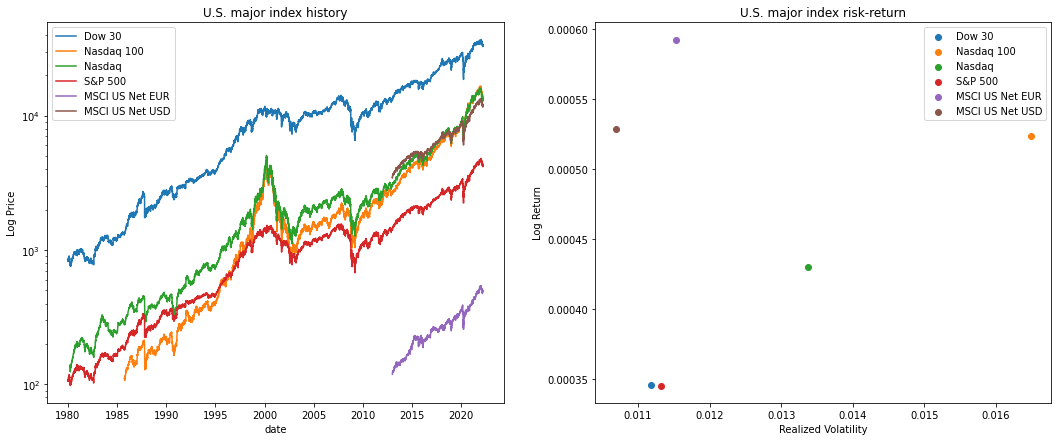

In [272]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
for index in df_major_index_history.name.unique():
    axes[0].set_title('U.S. major index history')
    axes[0].set_ylabel('Log Price')
    axes[0].set_xlabel('date')
    axes[0].set_yscale('log')
    axes[0].plot(df_major_index_history[df_major_index_history.name == index]['Close'] \
                 #/ index_history[(index_history.Symbol == index_etf)]['Close']['2008-1-3'], 
                 , label=index)
    
    
    axes[1].set_title('U.S. major index risk-return')
    axes[1].set_ylabel('Log Return')
    axes[1].set_xlabel('Realized Volatility')
    axes[1].scatter(df_major_index_history[df_major_index_history.name == index]['Close'].apply(np.log).diff().std(), \
                    df_major_index_history[df_major_index_history.name == index]['Close'].apply(np.log).diff().mean(), \
                   label=index)
    axes[0].legend()
    axes[1].legend()

### Download U.S. bond rates 

In [324]:
df_bonds = ip.bonds.get_bonds('united states')

def translate_bond_name_to_months(x):
    months = 0
    if 'Y' in x:
        months = 12 * int(re.findall(r'\d+', x)[0])
    if 'M' in x:
        months = int(re.findall(r'\d+', x)[0])
    return months

bond_histories = []
for bond in df_bonds.name.to_list():
    print(f'get {bond} history.')
    df_tmp = ip.bonds.get_bond_historical_data(bond, '01/01/1900', '10/03/2022')
    df_tmp['name'] = bond
    bond_histories.append(df_tmp)
    # Use time.sleep(10) to prevent your IP address getting blacklisted. ref: https://github.com/alvarobartt/investpy/issues/467#issuecomment-959318542
    time.sleep(10)
df_bond_history = pd.concat(bond_histories)
df_bond_history['name'] = df_bond_history['name'].astype(pd.api.types.CategoricalDtype(categories = ['U.S. 30Y', 'U.S. 20Y', 'U.S. 10Y', 'U.S. 7Y', 'U.S. 5Y', \
                                                                        'U.S. 3Y', 'U.S. 2Y', 'U.S. 1Y', 'U.S. 6M',  'U.S. 3M', 'U.S. 1M', ], orderd=True)).sort_values(by='name')
df_bond_history = df_bond_history.reset_index().sort_values(by=['Date', 'name']).set_index('Date')
df_bond_history['term'] = df_bond_history.name.apply(translate_bond_name_to_months)
df_bond_history.to_pickle('data/major_indices_history.pkl')
# df_bond_history = pd.read_pickle('data/major_indices_history.pkl')

get U.S. 30Y history.


ConnectionError: ERR#0015: error 429, try again later.

plot U.S. bond history and interest term structure at some points.

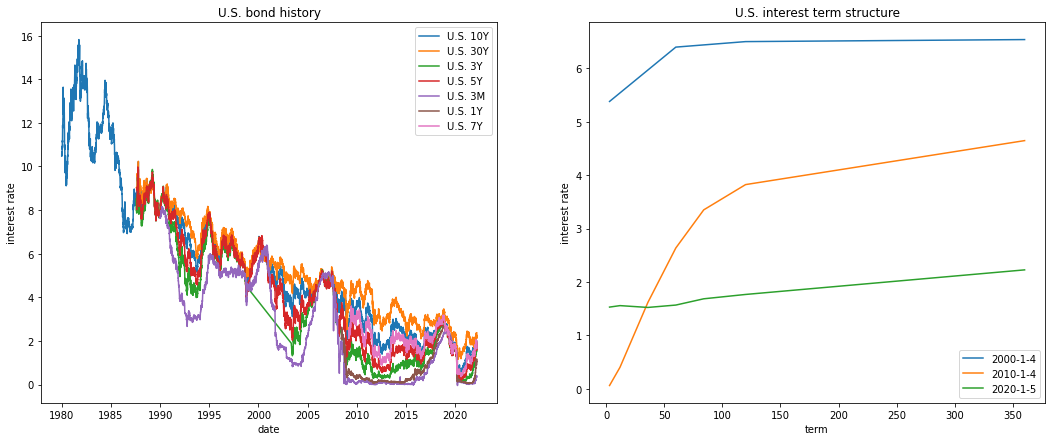

In [270]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
for bond in df_bond_history.name.unique():
    axes[0].set_title('U.S. bond history')
    axes[0].set_ylabel('interest rate')
    axes[0].set_xlabel('date')
    axes[0].plot(df_bond_history[df_bond_history.name == bond]['Close'], label=bond ) 

for date in ['2000-1-4', '2010-1-4', '2020-1-5']:
    axes[1].set_title('U.S. interest term structure')
    axes[1].set_ylabel('interest rate')
    axes[1].set_xlabel('term')
    axes[1].plot(df_bond_history.loc[date, 'term'].to_list(), df_bond_history.loc[date, 'Close'].to_list(), label=date)
    
axes[0].legend()
axes[1].legend()

### Download U.S. economic news

In [441]:
df_market_news = ip.news.economic_calendar(countries=['united states'], from_date='01/01/1900', to_date='10/03/2022', importances=['high'])
month_initials = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Q1', 'Q2', 'Q3', 'Q4']
df_market_news['event'] = df_market_news['event'].str.replace(f'  \(({"|".join(month_initials)})\)', '', regex=True)
df_market_news['event'] = df_market_news['event'].astype('category')
df_market_news = df_market_news.drop(columns=['id', 'time'])
df_market_news = df_market_news[~df_market_news['actual'].isna()]
df_market_news = df_market_news[~df_market_news['event'].str.contains('Speaks|US Federal Budget')]
df_market_news['date'] = pd.to_datetime(df_market_news['date'], format='%d/%m/%Y')

def to_numerical(x):
    x_str = str(x).replace(',', '')
    x_new = np.nan
    try:
        if '%' in x_str:
            x_new = float(x_str.replace('%', ''))
        elif 'M' in x_str:
            multiplier = 1000000
            x_new = multiplier * float(x_str.replace('M', ''))
        elif 'K' in x_str:
            multiplier = 1000
            x_new = multiplier * float(x_str.replace('K', ''))
        elif x_str != 'None':
            x_new = float(x_str)
        return x_new
    except Exception as e:
        print(e)
    
df_market_news['actual'] = df_market_news['actual'].apply(to_numerical)
df_market_news['forecast'] = df_market_news['forecast'].apply(to_numerical)
df_market_news['previous'] = df_market_news['previous'].apply(to_numerical)

plot U.S. economic indicator history.

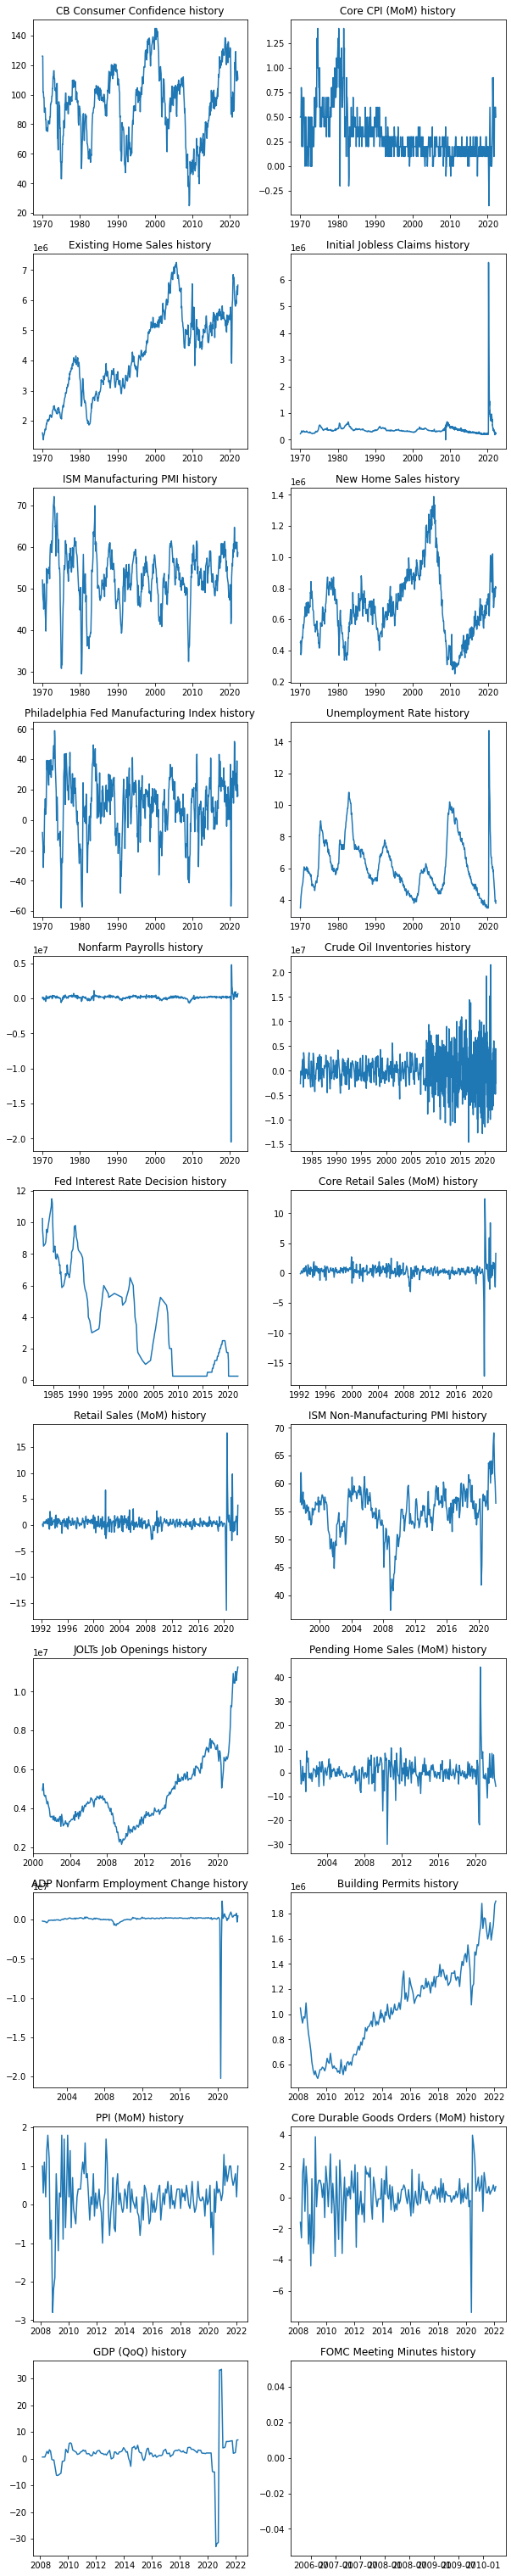

In [445]:
market_events = df_market_news.event.unique()
num_row = math.ceil(len(market_events) / 2)
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(5 * num_col, 5 * num_row))
for i, event in enumerate(market_events):
    idx_row = math.floor(i / num_col)
    idx_col = i % num_col
    df_event_tmp = df_market_news[df_market_news['event'] == event].copy()
    axes[idx_row, idx_col].set_title(f'{event} history')
    axes[idx_row, idx_col].plot(df_event_tmp['date'], df_event_tmp['actual'])

In [315]:
df_market_news

0                                   CB Consumer Confidence
1                                           Core CPI (MoM)
2                                      Existing Home Sales
3                                   Initial Jobless Claims
4                                    ISM Manufacturing PMI
                               ...                        
12385                     United States - Thanksgiving Day
12386    United States - Thanksgiving Day - Early close...
12387                            United States - Christmas
12388          United States - Martin Luther King, Jr. Day
12389                      United States - Presidents' Day
Name: event, Length: 12390, dtype: object